In [44]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
from einops import rearrange
from pytorch_lightning import seed_everything
try:
    from torch import autocast
except:
    from torch.cuda.amp import autocast
from contextlib import nullcontext
import json
from torchvision import transforms
import logging
from pnp_utils import check_safety

from pnp_ldm.util import instantiate_from_config
from pnp_ldm.models.diffusion.ddim import DDIMSampler
import collections

memory_storage = collections.defaultdict(dict)

def load_img(path):
    image = Image.open(path).convert("RGB")
    x, y = image.size
    print(f"loaded input image of size ({x}, {y}) from {path}")
    h = w = 512
    image = transforms.CenterCrop(min(x,y))(image)
    image = image.resize((w, h), resample=Image.Resampling.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

In [45]:
class Options:
    def __init__(self):
        self.config = "./configs/pnp_refine_all.yaml"
        self.img_dir_path = "/hdd3/junyi/DiffSketch/data"
        self.text_dir_path = "PATH_TO_CLASS_INFO"
        self.ddim_eta = 0.0
        self.save_all_features = True
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
        self.model_config = "configs/stable-diffusion/v1-inference.yaml"
        self.ckpt = "models/ldm/stable-diffusion-v1/model.ckpt"
        self.precision = "autocast"
        self.check_safety = False

opt = Options()
img_path="/hdd3/junyi/DiffSketch/experiments/sketch_79/refined/INJECTION_T_40_STEPS_50_NP-ALPHA_0.75_SCHEDULE_linear_NP_line_drawing,_simple,_smooth_sample_0.png"

In [2]:

setup_config = OmegaConf.load("./configs/pnp/setup.yaml")
model_config = OmegaConf.load(f"{opt.model_config}")
model = load_model_from_config(model_config, f"{opt.ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
unet_model = model.model.diffusion_model
sampler = DDIMSampler(model)

img_dir_path=opt.img_dir_path
img_paths=[]

# iterate through all images in the directory
for root, dirs, files in os.walk(img_dir_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            path = os.path.join(root, file)
            img_paths.append(path)



Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 840000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.mlp.fc2.bias', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.weight',

In [46]:
exp_config = OmegaConf.load(opt.config)
experiment_name =  exp_config.config.experiment_name+img_path.split("/")[-1].split(".")[0] # experiment_name + "01.jpg"
exp_path_root = setup_config.config.exp_path_root

exp_config.config.seed = -1
exp_config.config.prompt = ""
exp_config.config.scale = 1.0

seed = exp_config.config.seed 
seed_everything(seed)

save_feature_timesteps = exp_config.config.ddim_steps if exp_config.config.init_img == '' else exp_config.config.save_feature_timesteps

outpath = f"{exp_path_root}/{experiment_name}"

# if os.path.exists(outpath):
#     continue

callback_timesteps_to_save = [save_feature_timesteps]
if os.path.exists(outpath):
    logging.warning("Experiment directory already exists, previously saved content will be overriden")
    if exp_config.config.init_img != '':
        with open(os.path.join(outpath, "args.json"), "r") as f:
            args = json.load(f)
        callback_timesteps_to_save = args["save_feature_timesteps"] + callback_timesteps_to_save


sample_path = os.path.join(outpath, "inversion")
os.makedirs(outpath, exist_ok=True)
os.makedirs(sample_path, exist_ok=True)

# save parse_args in experiment dir
with open(os.path.join(outpath, "args.json"), "w") as f:
    args_to_save = OmegaConf.to_container(exp_config.config)
    args_to_save["save_feature_timesteps"] = callback_timesteps_to_save
    json.dump(args_to_save, f)

def ddim_sampler_callback(pred_x0, x_t, i):
    save_feature_maps_callback(i)
    # save_sampled_img(pred_x0, i, predicted_samples_path)

def save_feature_maps(blocks, i, feature_type="input_block"):
    block_idx = 0
    for block in tqdm(blocks, desc="Saving input blocks feature maps"):
        if not opt.save_all_features and block_idx < 4:
            block_idx += 1
            continue
        if "ResBlock" in str(type(block[0])):
            if opt.save_all_features or block_idx == 4:
                save_feature_map(block[0].in_layers_features, f"{feature_type}_{block_idx}_in_layers_features_time_{i}")
                save_feature_map(block[0].out_layers_features, f"{feature_type}_{block_idx}_out_layers_features_time_{i}")
        if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):
            save_feature_map(block[1].transformer_blocks[0].attn1.k, f"{feature_type}_{block_idx}_self_attn_k_time_{i}")
            save_feature_map(block[1].transformer_blocks[0].attn1.q, f"{feature_type}_{block_idx}_self_attn_q_time_{i}")
        block_idx += 1

def save_feature_maps_callback(i):
    if opt.save_all_features:
        save_feature_maps(unet_model.input_blocks, i, "input_block")
    save_feature_maps(unet_model.output_blocks , i, "output_block")

def save_feature_map(feature_map, filename):
    memory_storage[filename] = feature_map

# cls_name="cat" # TODO, pass the cls_name from text
cls_name = None

assert exp_config.config.prompt is not None
prompts = [exp_config.config.prompt.replace('object', cls_name)] if cls_name else [exp_config.config.prompt]

precision_scope = autocast if opt.precision=="autocast" else nullcontext
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            uc = model.get_learned_conditioning([""])
            if isinstance(prompts, tuple):
                prompts = list(prompts)
            c = model.get_learned_conditioning(prompts)
            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]

            z_enc = None
            if exp_config.config.init_img != '':
                assert os.path.isfile(img_path)
                init_image = load_img(img_path).to(device)
                init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))
                ddim_inversion_steps = 999
                z_enc, _ = sampler.encode_ddim(init_latent, num_steps=ddim_inversion_steps, conditioning=c,unconditional_conditioning=uc,unconditional_guidance_scale=exp_config.config.scale)
            else:
                z_enc = torch.randn([1, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)
            torch.save(z_enc, f"{outpath}/z_enc.pt")
            samples_ddim, _ = sampler.sample(S=exp_config.config.ddim_steps,
                            conditioning=c,
                            batch_size=1,
                            shape=shape,
                            verbose=False,
                            unconditional_guidance_scale=exp_config.config.scale,
                            unconditional_conditioning=uc,
                            eta=opt.ddim_eta,
                            x_T=z_enc,
                            img_callback=ddim_sampler_callback,
                            callback_ddim_timesteps=save_feature_timesteps,
                            outpath=outpath)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
            x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
            if opt.check_safety:
                x_samples_ddim = check_safety(x_samples_ddim)
            x_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)

            sample_idx = 0
            for x_sample in x_image_torch:
                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                img = Image.fromarray(x_sample.astype(np.uint8))
                img.save(os.path.join(sample_path, f"{sample_idx}.png"))
                sample_idx += 1

print(f"Sampled images and extracted features saved in: {outpath}")
exp_path_root_config = OmegaConf.load("./configs/pnp/setup.yaml")
exp_path_root = exp_path_root_config.config.exp_path_root

/home/junyi/miniconda3/envs/od/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py:60: UserWarning: -1 is not in bounds, numpy accepts from 0 to 4294967295
  rank_zero_warn(f"{seed} is not in bounds, numpy accepts from {min_seed_value} to {max_seed_value}")
Global seed set to 467327626


loaded input image of size (512, 512) from /hdd3/junyi/DiffSketch/experiments/sketch_79/refined/INJECTION_T_40_STEPS_50_NP-ALPHA_0.75_SCHEDULE_linear_NP_line_drawing,_simple,_smooth_sample_0.png
Running DDIM inversion with 999 timesteps


DDIM Inversion: 100%|██████████| 999/999 [01:19<00:00, 12.52it/s]


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 999 timesteps


DDIM Sampler:   0%|          | 2/999 [00:00<01:36, 10.30it/s]

Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]


DDIM Sampler:  90%|█████████ | 901/999 [01:29<00:09, 10.10it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 23.69 GiB total capacity; 20.23 GiB already allocated; 225.50 MiB free; 21.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Global seed set to 3533965183
loading source experiment features: 100%|██████████| 50/50 [00:00<00:00, 74818.12it/s]


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


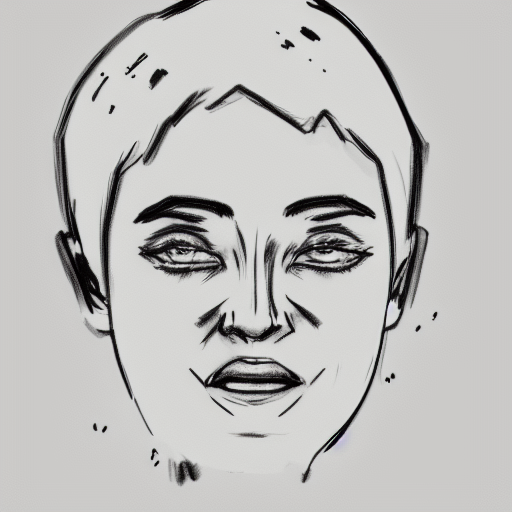

In [43]:
# inversion done, start refinement
exp_config.scale=20
exp_config.feature_injection_threshold=5
# read seed from args.json of source experiment
with open(os.path.join(exp_path_root, experiment_name, "args.json"), "r") as f:
    args = json.load(f)
    seed = args["seed"]
    source_prompt = args["prompt"]
negative_prompt = source_prompt if exp_config.negative_prompt is None else exp_config.negative_prompt

seed_everything(seed)
possible_ddim_steps = args["save_feature_timesteps"]
assert exp_config.num_ddim_sampling_steps in possible_ddim_steps or exp_config.num_ddim_sampling_steps is None, f"possible sampling steps for this experiment are: {possible_ddim_steps}; for {exp_config.num_ddim_sampling_steps} steps, run 'run_features_extraction.py' with save_feature_timesteps = {exp_config.num_ddim_sampling_steps}"
ddim_steps = exp_config.num_ddim_sampling_steps if exp_config.num_ddim_sampling_steps is not None else possible_ddim_steps[-1]

sampler = DDIMSampler(model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=opt.ddim_eta, verbose=False) 

seed = torch.initial_seed()
opt.seed = seed

outpaths = [os.path.join(f"{exp_path_root}/{experiment_name}/refined")]
out_label = f"INJECTION_T_{exp_config.feature_injection_threshold}_STEPS_{ddim_steps}"
out_label += f"_NP-ALPHA_{exp_config.negative_prompt_alpha}_SCHEDULE_{exp_config.negative_prompt_schedule}_NP_{negative_prompt.replace(' ', '_')}"

predicted_samples_paths = [os.path.join(outpath, f"predicted_samples_{out_label}") for outpath in outpaths]
for i in range(len(outpaths)):
    os.makedirs(outpaths[i], exist_ok=True)
    os.makedirs(predicted_samples_paths[i], exist_ok=True)
    # save args in experiment dir
    with open(os.path.join(outpaths[i], "args.json"), "w") as f:
        json.dump(OmegaConf.to_container(exp_config), f)

def ddim_sampler_callback(pred_x0, xt, i):
    # save_sampled_img(pred_x0, i, predicted_samples_paths)
    pass

def load_feature_map(filename):
    return memory_storage[filename]

def load_target_features():
    self_attn_output_block_indices = [4,5,6,7,8,9,10,11]
    out_layers_output_block_indices = [1,2,3,4,5,6,7,8,9,10,11]
    output_block_self_attn_map_injection_thresholds = [ddim_steps // 2] * len(self_attn_output_block_indices)
    feature_injection_thresholds = [exp_config.feature_injection_threshold]
    target_features = []

    time_range = np.flip(sampler.ddim_timesteps)
    total_steps = sampler.ddim_timesteps.shape[0]

    iterator = tqdm(time_range, desc="loading source experiment features", total=total_steps)

    for i, t in enumerate(iterator):
        current_features = {}
        for (output_block_idx, output_block_self_attn_map_injection_threshold) in zip(self_attn_output_block_indices, output_block_self_attn_map_injection_thresholds):
            if i <= int(output_block_self_attn_map_injection_threshold):
                output_q = load_feature_map(f"output_block_{output_block_idx}_self_attn_q_time_{t}")
                output_k = load_feature_map(f"output_block_{output_block_idx}_self_attn_k_time_{t}")
                current_features[f'output_block_{output_block_idx}_self_attn_q'] = output_q
                current_features[f'output_block_{output_block_idx}_self_attn_k'] = output_k

        for (output_block_idx, feature_injection_threshold) in zip(out_layers_output_block_indices, feature_injection_thresholds):
            if i <= int(feature_injection_threshold):
                output = load_feature_map(f"output_block_{output_block_idx}_out_layers_features_time_{t}")
                current_features[f'output_block_{output_block_idx}_out_layers'] = output

        target_features.append(current_features)

    return target_features # for one timestep, attn: (16, patch**2, dim); out_layers: (2, 1280, 16, 16)

batch_size = len(exp_config.prompts)
prompts = ["a photo of a face, extremely detailed, sketch style, high quality, sketchy, grayscale, black hair"]
assert prompts is not None

start_code_path = f"{exp_path_root}/{experiment_name}/z_enc.pt"
start_code = torch.load(start_code_path).cuda() if os.path.exists(start_code_path) else None
if start_code is not None:
    start_code = start_code.repeat(batch_size, 1, 1, 1)

precision_scope = autocast if opt.precision=="autocast" else nullcontext
injected_features = load_target_features()
unconditional_prompt = ""
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            uc = None
            nc = None
            if exp_config.scale != 1.0:
                uc = model.get_learned_conditioning(batch_size * [unconditional_prompt])
                nc = model.get_learned_conditioning(batch_size * [negative_prompt])
            if not isinstance(prompts, list):
                prompts = list(prompts)
            c = model.get_learned_conditioning(prompts)
            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            negative_conditioning=nc,
                                            batch_size=len(prompts),
                                            shape=shape,
                                            verbose=False,
                                            unconditional_guidance_scale=exp_config.scale,
                                            unconditional_conditioning=uc,
                                            eta=opt.ddim_eta,
                                            x_T=start_code,
                                            img_callback=ddim_sampler_callback,
                                            injected_features=injected_features,
                                            negative_prompt_alpha=exp_config.negative_prompt_alpha,
                                            negative_prompt_schedule=exp_config.negative_prompt_schedule,
                                            )

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
            x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
            if opt.check_safety:
                x_samples_ddim = check_safety(x_samples_ddim)
            x_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)

            sample_idx = 0
            for k, x_sample in enumerate(x_image_torch):
                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                img = Image.fromarray(x_sample.astype(np.uint8))
                # img.save(os.path.join(outpaths[k], f"{out_label}_sample_{sample_idx}.png"))
img